#  Nhận Diện Ngôn Ngữ Ký Hiệu VS
## Nhận diện được 36 kí tự


Kiểm tra chất lượng dữ liệu trước khi train
Chuẩn hóa (Normalize) features
Data Augmentation
Chỉ sử dụng HAND landmarks (quan trọng nhất cho sign language)

##  Cài đặt thư viện



In [1]:
!pip uninstall -y mediapipe
!pip install mediapipe==0.10.13 opencv-python-headless tensorflow scikit-learn tqdm

print('\n' + '='*60)
print('⚠️  RESTART RUNTIME: Runtime -> Restart runtime')

print('='*60)

Found existing installation: mediapipe 0.10.13
Uninstalling mediapipe-0.10.13:
  Successfully uninstalled mediapipe-0.10.13
  Using cached mediapipe-0.10.13-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.7 kB)
Using cached mediapipe-0.10.13-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (35.6 MB)

⚠️  RESTART RUNTIME: Runtime -> Restart runtime
Sau đó chạy từ Bước 2


In [5]:
!Runtime -> Restart runtime

/bin/bash: line 1: Runtime: command not found


In [12]:
# Cài phiên bản MediaPipe tương thích
!pip uninstall -y mediapipe
!pip install mediapipe==0.10.14 opencv-python-headless

# Kiểm tra cài đặt
import mediapipe as mp
print(f"✅ MediaPipe version: {mp.__version__}")

# Test xem solutions có hoạt động không
try:
    hands = mp.solutions.hands
    print("✅ mp.solutions.hands OK!")
except AttributeError:
    print("❌ Cần restart runtime!")

print("\n" + "="*60)
print("⚠️  RESTART RUNTIME: Runtime → Restart runtime")

print("="*60)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 18.6 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.8 which is incompatible.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 4.25.8 which is incompatible.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 4.25.8 which is incompatible.


✅ MediaPipe version: 0.10.31
❌ Cần restart runtime!

⚠️  RESTART RUNTIME: Runtime → Restart runtime
Sau đó chạy từ Bước 2 (KHÔNG chạy lại cell này)


##Mount Drive và chuẩn bị dữ liệu

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import os
import zipfile

ZIP_PATH = '/content/drive/MyDrive/project_VSL/dataset.zip'
EXTRACT_PATH = '/content/dataset'

if not os.path.exists(EXTRACT_PATH):
    print("Đang giải nén dataset...")
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall('/content/')
    print("Hoàn thành!")

# Kiểm tra và tìm đúng path dataset
def find_dataset_path(base_path):
    """Tìm thư mục chứa các label folders"""
    if not os.path.exists(base_path):
        return None

    contents = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]

    # Nếu có nhiều folder (>10), đây có thể là dataset path
    if len(contents) > 10:
        return base_path

    # Nếu chỉ có 1-2 folder, kiểm tra bên trong
    for folder in contents:
        inner_path = os.path.join(base_path, folder)
        inner_contents = [d for d in os.listdir(inner_path) if os.path.isdir(os.path.join(inner_path, d))]
        if len(inner_contents) > 10:
            return inner_path

    return base_path

DATASET_PATH = find_dataset_path(EXTRACT_PATH)
print(f"Dataset path: {DATASET_PATH}")

LABELS = sorted([d for d in os.listdir(DATASET_PATH)
                 if os.path.isdir(os.path.join(DATASET_PATH, d))])
print(f"Số lượng nhãn: {len(LABELS)}")
print(f"Các nhãn: {LABELS}")

Đang giải nén dataset...
Hoàn thành!
Dataset path: /content/dataset
Số lượng nhãn: 36
Các nhãn: ['a', 'ai', 'an', 'b', 'ban', 'bandem', 'baogio', 'bundau', 'buoichieu', 'buoisang', 'buoitrua', 'c', 'cacban', 'camon', 'cangay', 'chungtoi', 'd', 'dd', 'e', 'homqua', 'khoe', 'lucnao', 'may', 'muonkhong', 'ngoi', 'nha', 'odau', 'phaikhong', 'ten', 'thich', 'toi', 'tuoi', 'v', 'xinchao', 'xinloi', 'y']


## Import và cấu hình

In [8]:
import cv2
import numpy as np
import mediapipe as mp
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional, GRU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tqdm import tqdm
import pickle
import json
import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow: {tf.__version__}")
print(f"MediaPipe: {mp.__version__}")
print(f"GPU: {tf.config.list_physical_devices('GPU')}")

TensorFlow: 2.19.0
MediaPipe: 0.10.13
GPU: []


In [ ]:
!pip install mediapipe


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 4.9 MB/s eta 0:00:00
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0


In [9]:
# ===== CẤU HÌNH =====
SEQUENCE_LENGTH = 30  # Giảm xuống để model dễ học hơn
MODEL_SAVE_PATH = '/content/drive/MyDrive/project_VSL/models_v2'
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

NUM_CLASSES = len(LABELS)
print(f"Số lượng lớp: {NUM_CLASSES}")
print(f"Sequence length: {SEQUENCE_LENGTH}")

Số lượng lớp: 36
Sequence length: 30


##  MediaPipe - CHỈ dùng HANDS

In [10]:
# Sử dụng MediaPipe Hands thay vì Holistic
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

print("✅ MediaPipe Hands initialized!")

✅ MediaPipe Hands initialized!


In [11]:
def extract_hand_keypoints(results):
    """
    Trích xuất keypoints từ 2 tay.
    Mỗi tay có 21 landmarks × 3 (x, y, z) = 63 features
    2 tay = 126 features
    """
    # Khởi tạo zeros cho cả 2 tay
    left_hand = np.zeros(21 * 3)
    right_hand = np.zeros(21 * 3)

    if results.multi_hand_landmarks:
        for idx, hand_landmarks in enumerate(results.multi_hand_landmarks):
            # Lấy handedness (left/right)
            handedness = results.multi_handedness[idx].classification[0].label

            # Trích xuất landmarks
            landmarks = np.array([[lm.x, lm.y, lm.z] for lm in hand_landmarks.landmark]).flatten()

            # MediaPipe trả về tay ngược (mirror) từ camera
            if handedness == 'Left':  # Thực ra là tay phải người dùng
                right_hand = landmarks
            else:  # Right -> thực ra là tay trái
                left_hand = landmarks

    return np.concatenate([left_hand, right_hand])

# Số features
FEATURE_SIZE = 21 * 3 * 2  # = 126
print(f"Feature size: {FEATURE_SIZE}")

Feature size: 126


## Kiểm tra chất lượng dữ liệu TRƯỚC KHI train

In [12]:
def check_video_quality(video_path, num_samples=5):
    """
    Kiểm tra xem MediaPipe có detect được tay trong video không
    Return: tỷ lệ frames có detect được tay
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return 0.0

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total_frames == 0:
        cap.release()
        return 0.0

    # Sample một số frames
    frame_indices = np.linspace(0, total_frames - 1, num_samples, dtype=int)
    detected = 0

    with mp_hands.Hands(static_image_mode=True, max_num_hands=2,
                        min_detection_confidence=0.3) as hands:
        for frame_idx in frame_indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
            ret, frame = cap.read()
            if not ret:
                continue

            rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = hands.process(rgb)

            if results.multi_hand_landmarks:
                detected += 1

    cap.release()
    return detected / num_samples

# Kiểm tra chất lượng dataset
print("🔍 Kiểm tra chất lượng dataset...")
print("="*50)

quality_report = {}
total_good = 0
total_videos = 0

for label in tqdm(LABELS[:5], desc="Checking labels"):  # Check 5 labels đầu
    label_path = os.path.join(DATASET_PATH, label)
    videos = [f for f in os.listdir(label_path) if f.lower().endswith(('.mp4', '.avi', '.mov'))]

    good_videos = 0
    for video in videos[:5]:  # Check 5 videos mỗi label
        video_path = os.path.join(label_path, video)
        detection_rate = check_video_quality(video_path)

        if detection_rate > 0.5:  # Ít nhất 50% frames detect được tay
            good_videos += 1
        total_videos += 1

    quality_report[label] = good_videos
    total_good += good_videos

print(f"\n📊 Kết quả kiểm tra:")
for label, count in quality_report.items():
    print(f"  {label}: {count}/5 videos có tay được detect")

print(f"\n📈 Tổng: {total_good}/{total_videos} videos OK ({100*total_good/total_videos:.1f}%)")

if total_good/total_videos < 0.5:
    print("\n⚠️ CẢNH BÁO: Nhiều video không detect được tay!")
    print("Có thể do: ánh sáng yếu, tay ra ngoài khung hình, góc quay không tốt")

🔍 Kiểm tra chất lượng dataset...


Checking labels: 100%|██████████| 5/5 [00:40<00:00,  8.13s/it]


📊 Kết quả kiểm tra:
  a: 4/5 videos có tay được detect
  ai: 3/5 videos có tay được detect
  an: 2/5 videos có tay được detect
  b: 2/5 videos có tay được detect
  ban: 0/5 videos có tay được detect

📈 Tổng: 11/25 videos OK (44.0%)

⚠️ CẢNH BÁO: Nhiều video không detect được tay!
Có thể do: ánh sáng yếu, tay ra ngoài khung hình, góc quay không tốt


##  Trích xuất features với detection check

In [13]:
def process_video_v2(video_path, sequence_length=20):
    """
    Xử lý video và trích xuất hand keypoints.
    Trả về None nếu không detect được tay trong phần lớn frames.
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return None

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total_frames < 5:
        cap.release()
        return None

    # Sample frames
    if total_frames >= sequence_length:
        frame_indices = np.linspace(0, total_frames - 1, sequence_length, dtype=int)
    else:
        frame_indices = list(range(total_frames))

    keypoints_sequence = []
    detected_count = 0

    with mp_hands.Hands(
        static_image_mode=False,
        max_num_hands=2,
        min_detection_confidence=0.3,
        min_tracking_confidence=0.3
    ) as hands:
        for frame_idx in frame_indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
            ret, frame = cap.read()

            if not ret:
                keypoints_sequence.append(np.zeros(FEATURE_SIZE))
                continue

            rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = hands.process(rgb)

            keypoints = extract_hand_keypoints(results)
            keypoints_sequence.append(keypoints)

            # Đếm frames có detect được tay
            if results.multi_hand_landmarks:
                detected_count += 1

    cap.release()

    # Bỏ qua video nếu detect rate quá thấp
    detection_rate = detected_count / len(frame_indices)
    if detection_rate < 0.3:  # Ít nhất 30% frames phải detect được
        return None

    # Padding
    while len(keypoints_sequence) < sequence_length:
        keypoints_sequence.append(keypoints_sequence[-1] if keypoints_sequence else np.zeros(FEATURE_SIZE))

    return np.array(keypoints_sequence[:sequence_length])

In [14]:
# Thu thập dữ liệu
X_data = []
y_data = []
failed_videos = []
detection_stats = {}

print("🎬 Bắt đầu trích xuất features...")
print("="*60)

for label_idx, label in enumerate(LABELS):
    label_path = os.path.join(DATASET_PATH, label)
    video_files = [f for f in os.listdir(label_path)
                   if f.lower().endswith(('.mp4', '.avi', '.mov', '.mkv', '.webm'))]

    print(f"\n[{label_idx+1}/{len(LABELS)}] {label}: {len(video_files)} videos")

    success_count = 0
    for video_file in tqdm(video_files, desc=f"  Processing", leave=False):
        video_path = os.path.join(label_path, video_file)

        try:
            keypoints = process_video_v2(video_path, SEQUENCE_LENGTH)

            if keypoints is not None:
                X_data.append(keypoints)
                y_data.append(label)
                success_count += 1
            else:
                failed_videos.append(video_path)
        except Exception as e:
            failed_videos.append(video_path)

    detection_stats[label] = (success_count, len(video_files))
    print(f"  → Thành công: {success_count}/{len(video_files)}")

print("\n" + "="*60)
print(f"✅ Hoàn thành!")
print(f"   Tổng samples: {len(X_data)}")
print(f"   Videos lỗi/không detect được: {len(failed_videos)}")

🎬 Bắt đầu trích xuất features...

[1/36] a: 40 videos


  → Thành công: 40/40

[2/36] ai: 46 videos


  → Thành công: 46/46

[3/36] an: 51 videos


  → Thành công: 51/51

[4/36] b: 56 videos


  → Thành công: 56/56

[5/36] ban: 40 videos


  → Thành công: 25/40

[6/36] bandem: 48 videos


  → Thành công: 48/48

[7/36] baogio: 54 videos


  → Thành công: 54/54

[8/36] bundau: 30 videos


  → Thành công: 30/30

[9/36] buoichieu: 54 videos


  → Thành công: 54/54

[10/36] buoisang: 57 videos


  → Thành công: 56/57

[11/36] buoitrua: 56 videos


  → Thành công: 56/56

[12/36] c: 42 videos


  → Thành công: 39/42

[13/36] cacban: 28 videos


  → Thành công: 28/28

[14/36] camon: 52 videos


  → Thành công: 52/52

[15/36] cangay: 37 videos


  → Thành công: 37/37

[16/36] chungtoi: 54 videos


  → Thành công: 54/54

[17/36] d: 35 videos


  → Thành công: 34/35

[18/36] dd: 43 videos


  → Thành công: 43/43

[19/36] e: 37 videos


  → Thành công: 37/37

[20/36] homqua: 30 videos


  → Thành công: 30/30

[21/36] khoe: 31 videos


  → Thành công: 28/31

[22/36] lucnao: 42 videos


  → Thành công: 42/42

[23/36] may: 43 videos


  → Thành công: 43/43

[24/36] muonkhong: 27 videos


  → Thành công: 27/27

[25/36] ngoi: 44 videos


  → Thành công: 43/44

[26/36] nha: 34 videos


  → Thành công: 34/34

[27/36] odau: 44 videos


  → Thành công: 44/44

[28/36] phaikhong: 30 videos


  → Thành công: 30/30

[29/36] ten: 48 videos


  → Thành công: 47/48

[30/36] thich: 30 videos


  → Thành công: 30/30

[31/36] toi: 52 videos


  → Thành công: 45/52

[32/36] tuoi: 57 videos


  → Thành công: 57/57

[33/36] v: 55 videos


  → Thành công: 55/55

[34/36] xinchao: 42 videos


  → Thành công: 42/42

[35/36] xinloi: 44 videos


  → Thành công: 43/44

[36/36] y: 50 videos


  → Thành công: 49/50

✅ Hoàn thành!
   Tổng samples: 1529
   Videos lỗi/không detect được: 34


📊 Phân bố dữ liệu:
  a: 40 samples
  ai: 46 samples
  an: 51 samples
  b: 56 samples
  ban: 25 samples
  bandem: 48 samples
  baogio: 54 samples
  bundau: 30 samples
  buoichieu: 54 samples
  buoisang: 56 samples
  buoitrua: 56 samples
  c: 39 samples
  cacban: 28 samples
  camon: 52 samples
  cangay: 37 samples
  chungtoi: 54 samples
  d: 34 samples
  dd: 43 samples
  e: 37 samples
  homqua: 30 samples
  khoe: 28 samples
  lucnao: 42 samples
  may: 43 samples
  muonkhong: 27 samples
  ngoi: 43 samples
  nha: 34 samples
  odau: 44 samples
  phaikhong: 30 samples
  ten: 47 samples
  thich: 30 samples
  toi: 45 samples
  tuoi: 57 samples
  v: 55 samples
  xinchao: 42 samples
  xinloi: 43 samples
  y: 49 samples


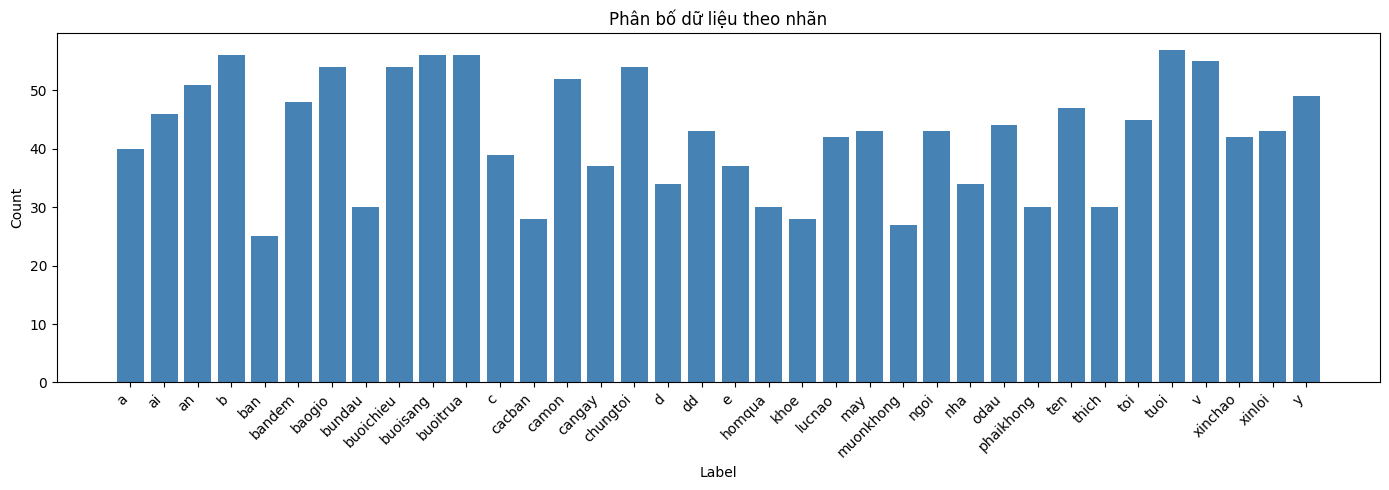

In [15]:
# Kiểm tra phân bố dữ liệu
import matplotlib.pyplot as plt
from collections import Counter

label_counts = Counter(y_data)
print("📊 Phân bố dữ liệu:")
for label, count in sorted(label_counts.items()):
    print(f"  {label}: {count} samples")

# Visualize
plt.figure(figsize=(14, 5))
labels_sorted = sorted(label_counts.keys())
counts = [label_counts[l] for l in labels_sorted]
plt.bar(labels_sorted, counts, color='steelblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Phân bố dữ liệu theo nhãn')
plt.tight_layout()
plt.show()

# Cảnh báo nếu mất cân bằng
min_count = min(counts)
max_count = max(counts)
if max_count / min_count > 3:
    print(f"\n⚠️ Dữ liệu mất cân bằng: min={min_count}, max={max_count}")

## Chuẩn hóa dữ liệu

In [16]:
# Chuyển sang numpy
X = np.array(X_data)
y = np.array(y_data)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

# QUAN TRỌNG: Chuẩn hóa dữ liệu
# Reshape để fit scaler
X_reshaped = X.reshape(-1, FEATURE_SIZE)
print(f"\nX reshaped: {X_reshaped.shape}")

# Kiểm tra giá trị trước chuẩn hóa
print(f"\nTrước chuẩn hóa:")
print(f"  Min: {X_reshaped.min():.4f}")
print(f"  Max: {X_reshaped.max():.4f}")
print(f"  Mean: {X_reshaped.mean():.4f}")
print(f"  Std: {X_reshaped.std():.4f}")

X shape: (1529, 30, 126)
y shape: (1529,)

X reshaped: (45870, 126)

Trước chuẩn hóa:
  Min: -0.3720
  Max: 1.1781
  Mean: 0.1345
  Std: 0.2534


In [17]:
# Chuẩn hóa với StandardScaler
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X_reshaped)

# Reshape lại về (samples, sequence, features)
X_normalized = X_normalized.reshape(-1, SEQUENCE_LENGTH, FEATURE_SIZE)

print(f"Sau chuẩn hóa:")
print(f"  Min: {X_normalized.min():.4f}")
print(f"  Max: {X_normalized.max():.4f}")
print(f"  Mean: {X_normalized.mean():.4f}")
print(f"  Std: {X_normalized.std():.4f}")

# Lưu scaler để dùng khi inference
with open(os.path.join(MODEL_SAVE_PATH, 'scaler.pkl'), 'wb') as f:
    pickle.dump(scaler, f)
print("\n✅ Đã lưu scaler!")

Sau chuẩn hóa:
  Min: -14.6052
  Max: 14.9751
  Mean: 0.0000
  Std: 1.0000

✅ Đã lưu scaler!


In [18]:
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded, num_classes=NUM_CLASSES)

print(f"Classes: {list(label_encoder.classes_)}")
print(f"y_categorical shape: {y_categorical.shape}")

# Lưu label encoder
with open(os.path.join(MODEL_SAVE_PATH, 'label_encoder.pkl'), 'wb') as f:
    pickle.dump(label_encoder, f)

Classes: [np.str_('a'), np.str_('ai'), np.str_('an'), np.str_('b'), np.str_('ban'), np.str_('bandem'), np.str_('baogio'), np.str_('bundau'), np.str_('buoichieu'), np.str_('buoisang'), np.str_('buoitrua'), np.str_('c'), np.str_('cacban'), np.str_('camon'), np.str_('cangay'), np.str_('chungtoi'), np.str_('d'), np.str_('dd'), np.str_('e'), np.str_('homqua'), np.str_('khoe'), np.str_('lucnao'), np.str_('may'), np.str_('muonkhong'), np.str_('ngoi'), np.str_('nha'), np.str_('odau'), np.str_('phaikhong'), np.str_('ten'), np.str_('thich'), np.str_('toi'), np.str_('tuoi'), np.str_('v'), np.str_('xinchao'), np.str_('xinloi'), np.str_('y')]
y_categorical shape: (1529, 36)


In [19]:
# Chia dữ liệu
X_train, X_test, y_train, y_test = train_test_split(
    X_normalized, y_categorical,
    test_size=0.2,
    random_state=42,
    stratify=y_categorical
)

print(f"Training: {X_train.shape[0]} samples")
print(f"Testing: {X_test.shape[0]} samples")
print(f"Input shape: {X_train.shape[1:]}")

Training: 1223 samples
Testing: 306 samples
Input shape: (30, 126)


##  Data Augmentation

In [20]:
def augment_sequence(sequence):
    """
    Augment một sequence bằng các techniques:
    1. Thêm noise nhỏ
    2. Scale nhẹ
    3. Time shift
    """
    augmented = []

    # 1. Thêm Gaussian noise
    noise = np.random.normal(0, 0.05, sequence.shape)
    augmented.append(sequence + noise)

    # 2. Scale
    scale = np.random.uniform(0.9, 1.1)
    augmented.append(sequence * scale)

    # 3. Time shift (dịch 1-2 frames)
    shift = np.random.randint(1, 3)
    shifted = np.roll(sequence, shift, axis=0)
    augmented.append(shifted)

    return augmented

# Augment training data
print("🔄 Augmenting training data...")
X_train_aug = list(X_train)
y_train_aug = list(y_train)

for i in tqdm(range(len(X_train)), desc="Augmenting"):
    augmented_samples = augment_sequence(X_train[i])
    for aug in augmented_samples:
        X_train_aug.append(aug)
        y_train_aug.append(y_train[i])

X_train_aug = np.array(X_train_aug)
y_train_aug = np.array(y_train_aug)

print(f"\nSau augmentation:")
print(f"  Training samples: {X_train.shape[0]} → {X_train_aug.shape[0]}")

🔄 Augmenting training data...


Augmenting: 100%|██████████| 1223/1223 [00:00<00:00, 3122.57it/s]



Sau augmentation:
  Training samples: 1223 → 4892


##  Xây dựng Model (Đơn giản hơn)

In [21]:
def build_simple_model(input_shape, num_classes):
    """
    Model đơn giản hơn để tránh overfitting với dataset nhỏ
    """
    model = Sequential([
        # Bidirectional LSTM cho học 2 chiều
        Bidirectional(LSTM(64, return_sequences=True), input_shape=input_shape),
        Dropout(0.3),

        Bidirectional(LSTM(64, return_sequences=False)),
        Dropout(0.3),

        # Dense layers
        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.3),

        Dense(num_classes, activation='softmax')
    ])
    return model

# Build model
input_shape = (SEQUENCE_LENGTH, FEATURE_SIZE)
model = build_simple_model(input_shape, NUM_CLASSES)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 30, 128)        │        97,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 36)             │         2,340 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 207,204 (809.39 KB)

 Trainable params: 207,204 (809.39 KB)

 Non-trainable params: 0 (0.00 B)

##  Huấn luyện

In [22]:
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=20,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath=os.path.join(MODEL_SAVE_PATH, 'best_model.keras'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-6,
        verbose=1
    )
]

print("🏋️ Bắt đầu huấn luyện...")
print("="*50)

history = model.fit(
    X_train_aug, y_train_aug,
    validation_data=(X_test, y_test),
    epochs=150,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

🏋️ Bắt đầu huấn luyện...
Epoch 1/150
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.1837 - loss: 3.7307
Epoch 1: val_accuracy improved from -inf to 0.61111, saving model to /content/drive/MyDrive/project_VSL/models_v2/best_model.keras
153/153 ━━━━━━━━━━━━━━━━━━━━ 29s 107ms/step - accuracy: 0.1847 - loss: 3.7262 - val_accuracy: 0.6111 - val_loss: 1.8588 - learning_rate: 0.0010
Epoch 2/150
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.6109 - loss: 1.7108
Epoch 2: val_accuracy improved from 0.61111 to 0.73856, saving model to /content/drive/MyDrive/project_VSL/models_v2/best_model.keras
153/153 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - accuracy: 0.6112 - loss: 1.7097 - val_accuracy: 0.7386 - val_loss: 1.2682 - learning_rate: 0.0010
Epoch 3/150
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.7559 - loss: 1.1441
Epoch 3: val_accuracy improved from 0.73856 to 0.80392, saving model to /content/drive/MyDrive/project_VSL/models_v2/best_model.keras
153/153 ━━━━━━━━━━━━━━━━━

## Đánh giá

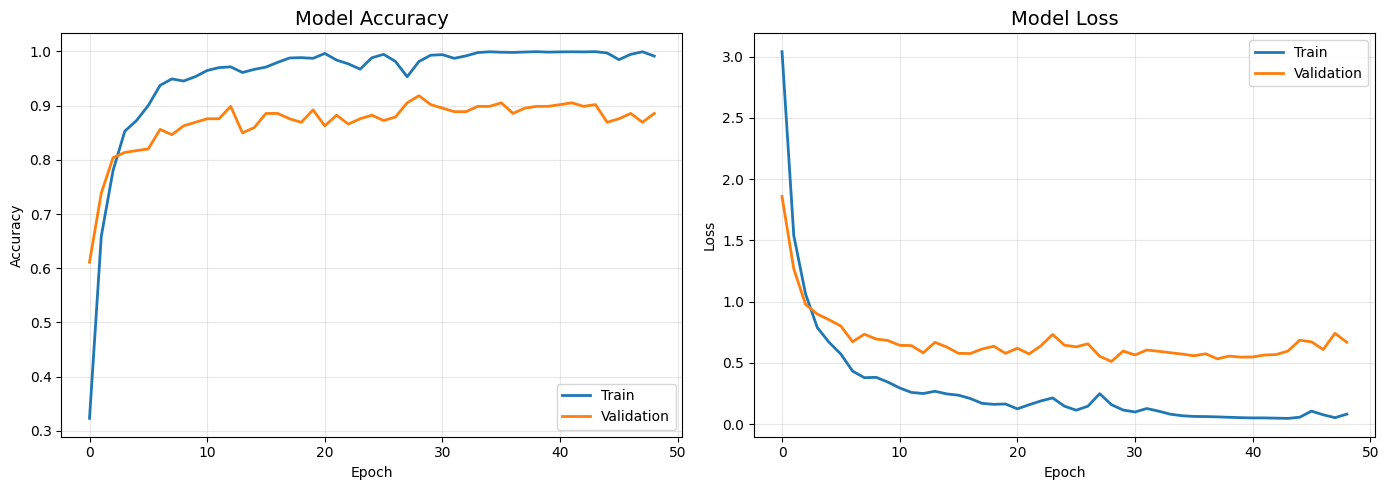


🎯 Best validation accuracy: 91.83%


In [23]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
axes[0].plot(history.history['accuracy'], label='Train', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation', linewidth=2)
axes[0].set_title('Model Accuracy', fontsize=14)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss
axes[1].plot(history.history['loss'], label='Train', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation', linewidth=2)
axes[1].set_title('Model Loss', fontsize=14)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(MODEL_SAVE_PATH, 'training_history.png'), dpi=150)
plt.show()

# Best accuracy
best_val_acc = max(history.history['val_accuracy'])
print(f"\n🎯 Best validation accuracy: {best_val_acc:.2%}")

In [24]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Đánh giá
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print("📊 Classification Report:")
print("="*50)
print(classification_report(y_true_classes, y_pred_classes,
                            target_names=label_encoder.classes_))

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step
📊 Classification Report:
              precision    recall  f1-score   support

           a       1.00      0.88      0.93         8
          ai       1.00      1.00      1.00         9
          an       0.91      1.00      0.95        10
           b       0.91      0.91      0.91        11
         ban       0.75      0.60      0.67         5
      bandem       1.00      0.90      0.95        10
      baogio       0.85      1.00      0.92        11
      bundau       0.75      1.00      0.86         6
   buoichieu       1.00      1.00      1.00        11
    buoisang       1.00      1.00      1.00        11
    buoitrua       1.00      0.91      0.95        11
           c       0.86      0.75      0.80         8
      cacban       1.00      0.83      0.91         6
       camon       0.91      1.00      0.95        10
      cangay       1.00      1.00      1.00         7
    chungtoi       1.00      1.00      1.00        11
           d   

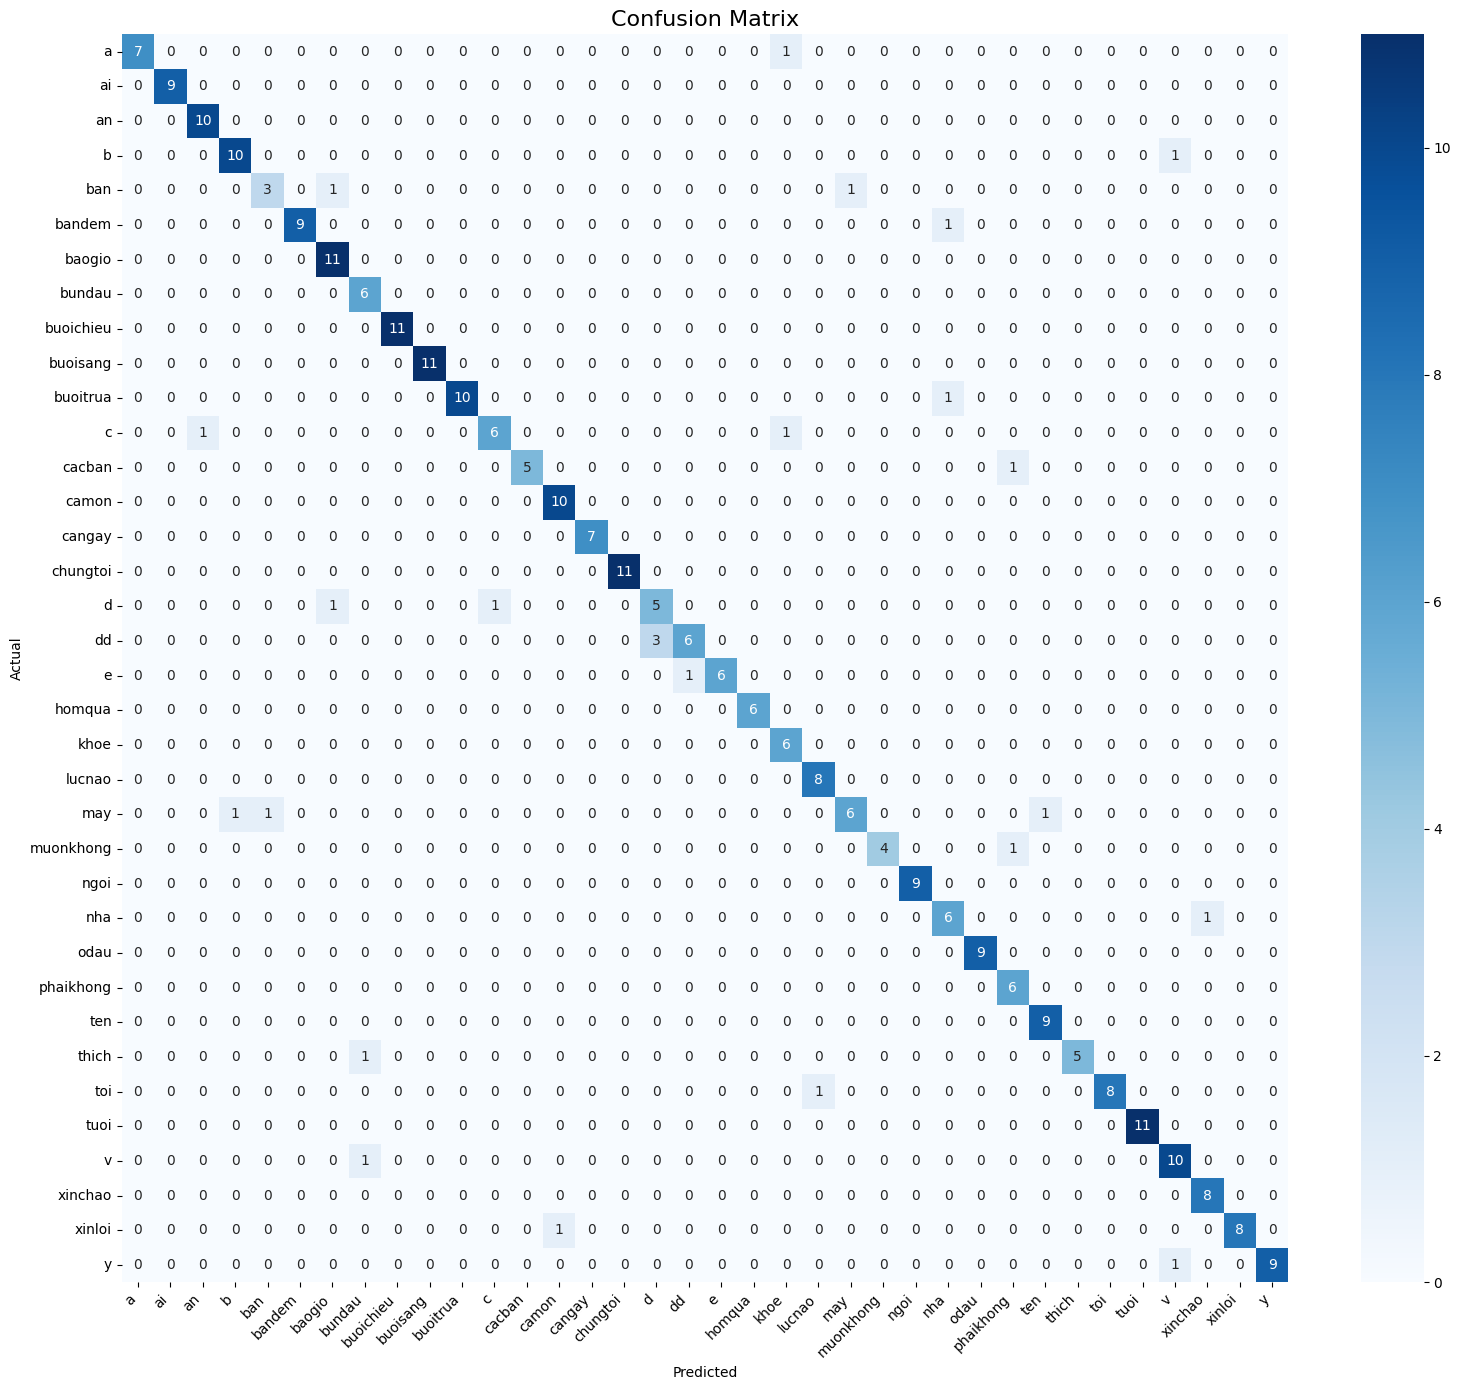

In [25]:
# Confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(16, 14))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(os.path.join(MODEL_SAVE_PATH, 'confusion_matrix.png'), dpi=150)
plt.show()

## Lưu model

In [26]:
# Lưu model
model.save(os.path.join(MODEL_SAVE_PATH, 'vsl_model.keras'))
model.save(os.path.join(MODEL_SAVE_PATH, 'vsl_model.h5'))

# Lưu config
config = {
    'labels': list(label_encoder.classes_),
    'sequence_length': SEQUENCE_LENGTH,
    'feature_size': FEATURE_SIZE,
    'num_classes': NUM_CLASSES,
    'use_hands_only': True,
    'best_val_accuracy': float(best_val_acc)
}
with open(os.path.join(MODEL_SAVE_PATH, 'config.json'), 'w') as f:
    json.dump(config, f, indent=2)

print("✅ Đã lưu model và config!")
print(f"📁 Đường dẫn: {MODEL_SAVE_PATH}")

# Liệt kê files
for f in os.listdir(MODEL_SAVE_PATH):
    size = os.path.getsize(os.path.join(MODEL_SAVE_PATH, f)) / 1024
    print(f"  - {f}: {size:.1f} KB")

✅ Đã lưu model và config!
📁 Đường dẫn: /content/drive/MyDrive/project_VSL/models_v2
  - scaler.pkl: 3.4 KB
  - label_encoder.pkl: 1.5 KB
  - best_model.keras: 2491.7 KB
  - training_history.png: 101.0 KB
  - confusion_matrix.png: 223.7 KB
  - vsl_model.keras: 2491.7 KB
  - vsl_model.h5: 2493.9 KB
  - config.json: 0.6 KB


In [27]:
# Download
from google.colab import files
import shutil

zip_path = '/content/vsl_model_v2.zip'
shutil.make_archive('/content/vsl_model_v2', 'zip', MODEL_SAVE_PATH)

print("📦 Downloading model package...")
files.download(zip_path)

📦 Downloading model package...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>